In [2]:
import h5py
import time
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from simarUtils import *

In [23]:
# T_cam_base = EXTRINSICS["humanoidJan19"]

#Internal realsense numbers
# intrinsics = np.array([
#     [616.0, 0.0, 313.4, 0.0],
#     [0.0, 615.7, 236.7, 0.0],
#     [0.0, 0.0, 1.0, 0.0]
# ])

T_cam_base = EXTRINSICS["humanoidFeb29R"]
intrinsics = WIDE_LENS_ROBOT_LEFT_K

In [3]:
T_cam_base, intrinsics

(array([[ 0.044, -0.721,  0.692, -0.215],
        [ 0.997,  0.071,  0.011, -0.365],
        [-0.058,  0.69 ,  0.722, -0.59 ],
        [ 0.   ,  0.   ,  0.   ,  1.   ]]),
 array([[132.93575589,   0.        , 162.58328357,   0.        ],
        [  0.        , 132.89940771, 122.23118857,   0.        ],
        [  0.        ,   0.        ,   1.        ,   0.        ]]))

## Hand Data

In [4]:
h5py_file = h5py.File("/coc/flash7/datasets/v1_datasetMimicplay.hdf5", "r")
nested_ds_print(h5py_file)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/coc/flash7/datasets/v1_datasetMimicplay.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def scatter_3d(points, angle=0):
    """
        make a 3d scatter plot for points of shape (Time, 3) where 3 is x,y,z
        color the points by time, make the axis interactive
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(points[:,0], points[:,1], points[:,2], c=range(points.shape[0]))
    #rotate the 3d plot
    ax.view_init(15, angle)
    # plt.show()


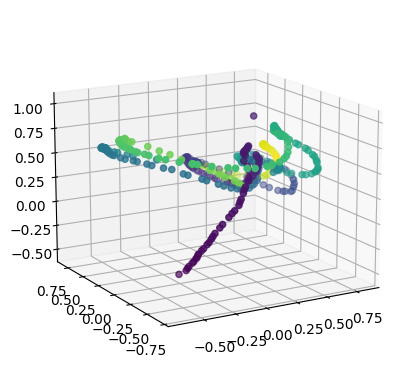

In [ ]:
h5py_file["data/demo_0/obs/ee_pose"].shape
scatter_3d(h5py_file["data/demo_0/obs/ee_pose"][0:500, :3], -120)

In [ ]:
h5py_file["data/demo_0/obs/ee_pose"][100:110][:]

array([[0.25087689, 0.63876992, 0.3117824 ],
       [0.24759885, 0.64367258, 0.31197703],
       [0.23768477, 0.65044251, 0.31343881],
       [0.23626664, 0.65154879, 0.31593795],
       [0.23513838, 0.65129797, 0.31912014],
       [0.23558765, 0.64312435, 0.32449542],
       [0.23891805, 0.63444794, 0.32655544],
       [0.25876513, 0.58324082, 0.32659283],
       [0.27036041, 0.54111614, 0.31844871],
       [0.32412908, 0.42706176, 0.29315451]])

In [ ]:
h5py_file["data/demo_0/actions"][100][:]

array([ 0.59811054,  0.03543127,  0.14237831,  0.77236677,  0.44158757,
        0.2631618 ,  0.68736354,  0.57589399,  0.2780353 ,  0.69624505,
        0.56116187,  0.28456462,  0.1453656 , -0.25412078,  0.32879276,
       -0.58054082,  0.07200848,  0.63641445, -0.6727051 ,  0.39087192,
        0.68561201, -0.6352771 ,  0.38843134,  0.67597828,  0.59799207,
        0.05013302,  0.39880089,  0.61521896,  0.56401076,  0.35426388])

In [ ]:
def project_3d_to_2d(x, y, z):
    # focal_length_x, focal_length_y, principal_point_x, principal_point_y
    camera_intrinsics = (616.16, 615.714, 313.42, 236.67)
    focal_length_x, focal_length_y, principal_point_x, principal_point_y = camera_intrinsics

    # Apply camera intrinsics to project 3D point to 2D
    u = (focal_length_x * x / z) + principal_point_x
    v = (focal_length_y * y / z) + principal_point_y

    return u, v

[ 17.771406 122.093536 427.196381]
Pixel value (339.0523087178962, 412.642229092231)


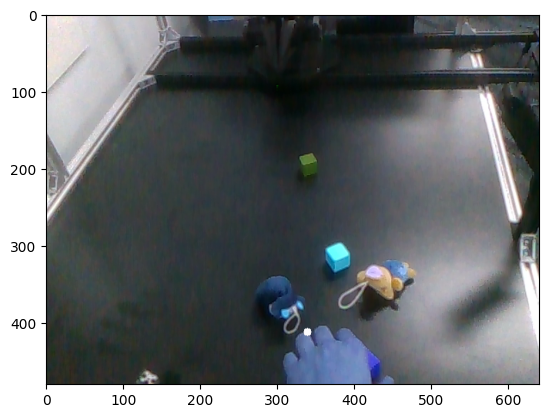

In [ ]:
T = 100
hand_loc = h5py_file["data/demo_0/obs/ee_pose_unnorm"][T][0:3]
print(hand_loc)
px_val = project_3d_to_2d(hand_loc[0], hand_loc[1], hand_loc[2])
# px_val = cam_frame_to_cam_pixels(hand_loc, intrinsics)
print("Pixel value", px_val)
frame = draw_dot_on_frame(h5py_file["data/demo_0/obs/front_image_1"][T], px_val, show=True)


In [ ]:
# Robot frame is x (forward pos), y(left pos), z (up pos)

video = torch.zeros(h5py_file["data/demo_0/obs/front_image_1"][:400].shape)
for t in range(400):
    # hand_loc = h5py_file["demo_0/obs/ee_pose"][t][0, 0:3]
    hand_loc = h5py_file["data/demo_0/obs/ee_pose_unnorm"][t][0:3]
    # print(hand_loc)
    # px_val = cam_frame_to_cam_pixels(hand_loc, intrinsics)
    px_val = project_3d_to_2d(hand_loc[0], hand_loc[1], hand_loc[2])
    # print("Pixel value", px_val)
    frame = draw_dot_on_frame(h5py_file["data/demo_0/obs/front_image_1"][t], px_val, show=False)
    video[t] = torch.from_numpy(frame)
torchvision.io.write_video("hand_traj.mp4", video, fps=30)

[-91.167618  13.367264 155.983826]
Pixel value (-46.706052472132626, 289.4345192296796)
[-87.11898    1.692047 175.914917]
Pixel value (8.276856756496727, 242.59227790755233)
[-85.787354   0.189011 184.086578]
Pixel value (26.279369678543333, 237.3021847041667)
[-84.575462  -1.690506 191.314972]
Pixel value (41.0314037435607, 231.22940013265662)
[-81.763176  -5.38826  203.658661]
Pixel value (66.04923620930614, 220.37986482308256)
[-80.613861  -7.417694 209.589645]
Pixel value (76.42815532294071, 214.87895186154827)
[-79.805145 -11.247711 221.592468]
Pixel value (91.51381976286308, 205.41725394252114)
[-79.678963 -13.758972 227.136108]
Pixel value (97.27211283940821, 199.37257617512753)
[-80.461876 -16.74884  237.264114]
Pixel value (104.46556234677783, 193.20579844881217)
[-80.905907 -19.650848 243.702789]
Pixel value (108.8635242137504, 187.02222093633077)
[-81.139793 -26.493973 259.204468]
Pixel value (120.54101438436629, 173.73624651345898)
[-80.874207 -30.725555 268.136658]
Pixel 

In [ ]:
video.shape

torch.Size([400, 480, 640, 3])

In [ ]:
video.shape

torch.Size([400, 480, 640, 3])

## Robot Data

## Calibration Data

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as Rot
import json
from simarUtils import *
import torchvision

In [2]:
data = h5py.File("/coc/flash7/datasets/egoplay/test_ds_apr19/testMimicplay.hdf5", "r")

In [3]:
nds(data)

dict with keys:  <KeysViewHDF5 ['data']>
data: dict with keys:  <KeysViewHDF5 ['demo_0', 'demo_1', 'demo_10']>
	demo_0: dict with keys:  <KeysViewHDF5 ['actions_joints', 'actions_xyz', 'obs']>
		actions_joints: (500, 7)
		actions_xyz: (500, 3)
		obs: dict with keys:  <KeysViewHDF5 ['ee_pose', 'front_img_1', 'joint_positions', 'right_wrist_img']>
			ee_pose: (500, 3)
			front_img_1: (500, 480, 640, 3)
			joint_positions: (500, 7)
			right_wrist_img: (500, 480, 640, 3)
	demo_1: dict with keys:  <KeysViewHDF5 ['actions_joints', 'actions_xyz', 'obs']>
		actions_joints: (500, 7)
		actions_xyz: (500, 3)
		obs: dict with keys:  <KeysViewHDF5 ['ee_pose', 'front_img_1', 'joint_positions', 'right_wrist_img']>
			ee_pose: (500, 3)
			front_img_1: (500, 480, 640, 3)
			joint_positions: (500, 7)
			right_wrist_img: (500, 480, 640, 3)
	demo_10: dict with keys:  <KeysViewHDF5 ['actions_joints', 'actions_xyz', 'obs']>
		actions_joints: (500, 7)
		actions_xyz: (500, 3)
		obs: dict with keys:  <KeysView

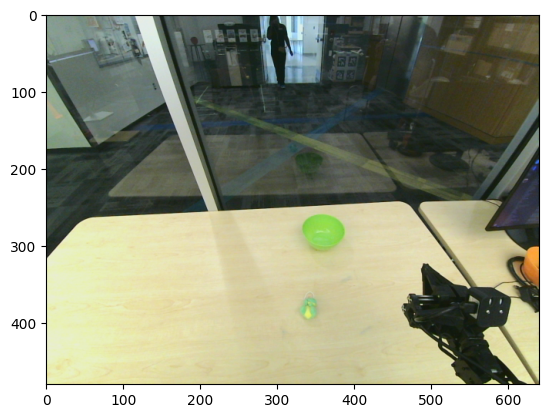

In [4]:
plt.imshow(data["data/demo_0/obs/front_img_1"][0])

In [3]:
data = h5py.File("/coc/flash7/datasets/egoplay/oboov2_robot_apr16/oboov2_robot_apr16Mimicplay_copy.hdf5", "r")
# demo = h5py.File("/coc/flash7/datasets/egoplay/bowl_place_hand_mar1/robomimic/converted_episodes/plushiesMimicplay.hdf5", "r")
# data = h5py.File("/coc/flash7/datasets/egoplay/one_bowl_one_object_robot_apr9/robomimic/oboo_apr9Mimicplay.hdf5", "r")
# data = h5py.File("/coc/flash7/datasets/egoplay/one_bowl_one_object/plushiesACT.hdf5", "r")

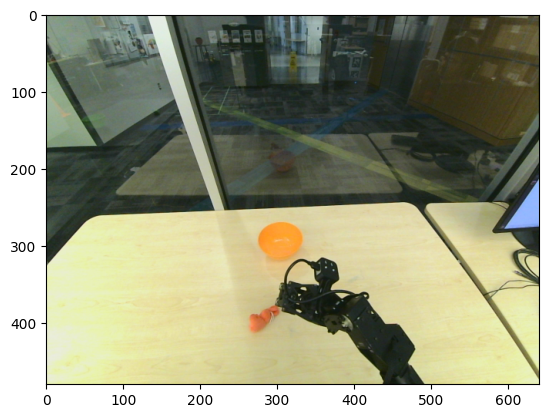

In [4]:
# swap bgr rgb
plt.imshow(data["data/demo_3/obs/front_img_1"][100].astype(np.uint8))
# plt.imshow(demo["data/demo_3/obs/front_img_1"][300].astype(np.uint8))

In [6]:
nds(data)

dict with keys:  <KeysViewHDF5 ['data', 'mask']>
data: dict with keys:  <KeysViewHDF5 ['demo_0', 'demo_1', 'demo_10', 'demo_100', 'demo_101', 'demo_102', 'demo_103', 'demo_104', 'demo_105', 'demo_106', 'demo_107', 'demo_108', 'demo_109', 'demo_11', 'demo_110', 'demo_111', 'demo_112', 'demo_113', 'demo_114', 'demo_115', 'demo_116', 'demo_117', 'demo_118', 'demo_119', 'demo_12', 'demo_120', 'demo_121', 'demo_122', 'demo_123', 'demo_124', 'demo_125', 'demo_126', 'demo_127', 'demo_128', 'demo_129', 'demo_13', 'demo_130', 'demo_131', 'demo_132', 'demo_133', 'demo_134', 'demo_135', 'demo_136', 'demo_137', 'demo_138', 'demo_139', 'demo_14', 'demo_140', 'demo_141', 'demo_142', 'demo_143', 'demo_144', 'demo_145', 'demo_146', 'demo_147', 'demo_148', 'demo_149', 'demo_15', 'demo_150', 'demo_151', 'demo_152', 'demo_153', 'demo_154', 'demo_155', 'demo_156', 'demo_157', 'demo_158', 'demo_159', 'demo_16', 'demo_160', 'demo_161', 'demo_162', 'demo_163', 'demo_164', 'demo_165', 'demo_166', 'demo_167', 

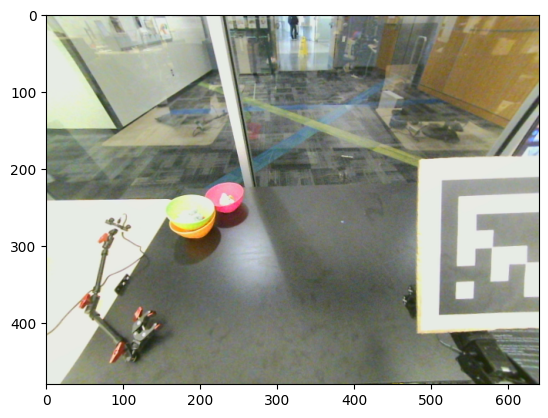

In [6]:
h, w, _ = demo["obs/front_img_1"][0].shape
# newcameramtx, roi = cv2.getOptimalNewCameraMatrix(WIDE_LENS_ROBOT_LEFT_K, WIDE_LENS_ROBOT_LEFT_D, (w,h), 1, (w,h))
# viz = cv2.undistort(demo["obs/front_img_1"][0], WIDE_LENS_ROBOT_LEFT_K[:, :3], WIDE_LENS_ROBOT_LEFT_D, None, newcameramtx)
viz = cv2.undistort(demo["obs/front_img_1"][0], WIDE_LENS_ROBOT_LEFT_K[:, :3], WIDE_LENS_ROBOT_LEFT_D)
plt.imshow(viz)

## Visualize normalized Cam Frame EE pose / Actions

[[-0.02   0.02   0.695]
 [-0.019  0.02   0.698]
 [-0.018  0.019  0.701]
 [-0.016  0.019  0.704]
 [-0.015  0.018  0.706]]


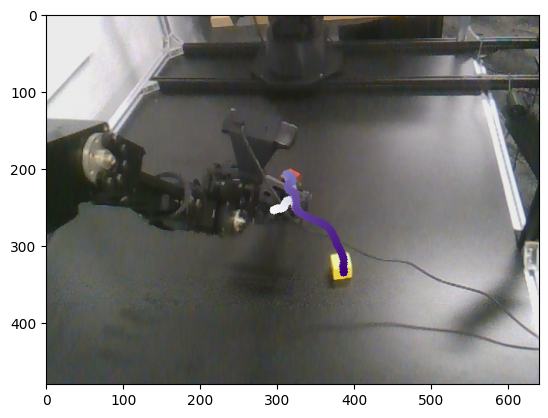

In [ ]:
T = 100
# point = demo["obs/ee_pose"][T][:3][None, :]
points = demo["obs/ee_pose"][T:T+150][:, :3]
mins = meta["obs_mins"]
maxs = meta["obs_maxs"]
points[:, 0] = general_unnorm(points[:, 0], mins[0], maxs[0], -1, 1)
points[:, 1] = general_unnorm(points[:, 1], mins[1], maxs[1], -1, 1)
points[:, 2] = general_unnorm(points[:, 2], mins[2], maxs[2], -1, 1)
print(points.round(3)[:5])
px_val = cam_frame_to_cam_pixels(points, intrinsics)
plt.imshow(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False))

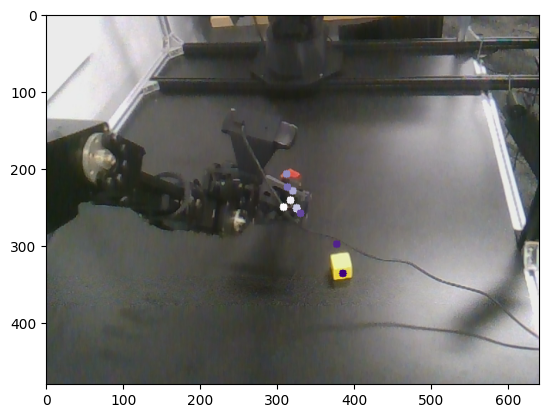

In [ ]:
T = 100
# point = demo["obs/ee_pose"][T][:3][None, :]
points = demo["actions"][T].reshape(-1, 3)
mins = meta["obs_mins"]
maxs = meta["obs_maxs"]
points[:, 0] = general_unnorm(points[:, 0], mins[0], maxs[0], -1, 1)
points[:, 1] = general_unnorm(points[:, 1], mins[1], maxs[1], -1, 1)
points[:, 2] = general_unnorm(points[:, 2], mins[2], maxs[2], -1, 1)

px_val = cam_frame_to_cam_pixels(points, intrinsics)
plt.imshow(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False))

## Visualize Unnormalized Cam Frame EE_pose

In [8]:
nds(data["data/demo_3"])

dict with keys:  <KeysViewHDF5 ['actions', 'obs']>
actions: (119, 3)
obs: dict with keys:  <KeysViewHDF5 ['Gripper_position', 'ee_pose', 'ee_pose_full_unnorm', 'front_image_1', 'front_image_2', 'wrist_cam_1']>
	Gripper_position: ()
	ee_pose: (119, 3)
	ee_pose_full_unnorm: (119, 7)
	front_image_1: (119, 480, 640, 3)
	front_image_2: (1, 1920, 1080, 3)
	wrist_cam_1: (1, 640, 480, 3)


px val:  (50, 3)


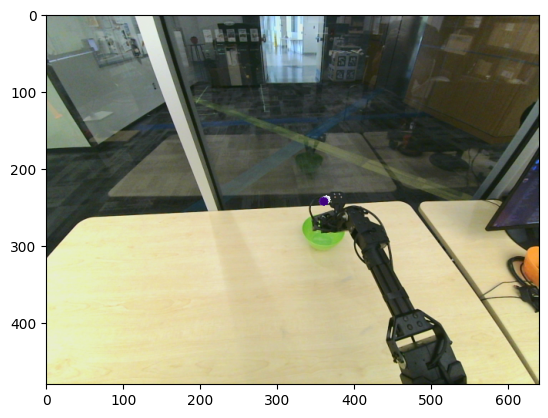

In [14]:
demo=data["data/demo_0"]
T = 300
# point = demo["obs/ee_pose"][T][:3][None, :]
# points = demo["obs/ee_pose"][T:T+50][:, :3]
points = demo["actions_xyz"][T:T+50]
# points = np.array([[0.5, 0., 1]])
px_val = cam_frame_to_cam_pixels(points, WIDE_LENS_ROBOT_LEFT_K)
print("px val: ", px_val.shape)
# plt.imshow(cv2.cvtColor(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False), cv2.COLOR_BGR2RGB))
plt.imshow(draw_dot_on_frame(demo["obs/front_img_1"][T], px_val, show=False))

In [17]:
demo=data["data/demo_0"]
imgs_tensor=torch.Tensor(*demo["obs/front_img_1"].shape)

for i in range(len(demo["obs/front_img_1"])):
    # inverted robot: (x forward, y right, z down) right handed frame
    # point = demo["obs/ee_pose"][T][:3][None, :]
    # points = demo["obs/ee_pose"][i:i+40][:, :3]
    points = demo["actions_xyz"][i].reshape(-1, 3)
    px_val = cam_frame_to_cam_pixels(points, WIDE_LENS_ROBOT_LEFT_K)
    imgs_tensor[i]=torch.Tensor(draw_dot_on_frame(demo["obs/front_img_1"][i], px_val, show=False))
torchvision.io.write_video("viz0.mp4",imgs_tensor,fps=30)

## Unnormalized Robot Frame EE_Pose

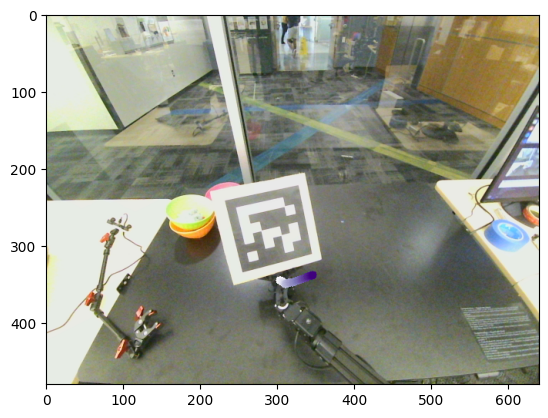

In [7]:
T = 400
# inverted robot: (x forward, y right, z down) right handed frame
# point = demo["obs/ee_pose"][T][:3][None, :]
points = demo["obs/ee_pose"][T:T+50][:, :3]
px_val = ee_pose_to_cam_pixels(points, EXTRINSICS["humanoidFeb29R"], WIDE_LENS_ROBOT_LEFT_K)
viz = demo["obs/front_img_1"][T]
# viz = cv2.undistort(viz, WIDE_LENS_ROBOT_LEFT_K[:, :3], WIDE_LENS_ROBOT_LEFT_D)
viz = draw_dot_on_frame(viz, px_val, show=False)
plt.imshow(viz)

In [13]:
imgs_tensor=torch.Tensor(*demo["obs/front_img_1"].shape)

for i in range(len(demo["obs/front_img_1"])):
    # inverted robot: (x forward, y right, z down) right handed frame
    # point = demo["obs/ee_pose"][T][:3][None, :]
    points = demo["obs/ee_pose"][i:i+50][:, :3]
    px_val = ee_pose_to_cam_pixels(points, EXTRINSICS["humanoidFeb29R"], WIDE_LENS_ROBOT_LEFT_K)
    viz = demo["obs/front_img_1"][i]
    viz = cv2.undistort(viz, WIDE_LENS_ROBOT_LEFT_K[:, :3], WIDE_LENS_ROBOT_LEFT_D)
    viz = draw_dot_on_frame(viz, px_val, show=False)
    imgs_tensor[i]=torch.Tensor(viz)
torchvision.io.write_video("viz.mp4",imgs_tensor,fps=30)

## Raw Aloha Data

In [13]:
from modern_robotics import FKinSpace

In [15]:
# demo = h5py.File("/home/rl2-aloha/interbotix_ws/src/aloha/aloha_scripts/data/humanoid_stacking_rand/red_on_yellow_v2.hdf5", "r")
demo = h5py.File("/home/rl2-aloha/interbotix_ws/src/aloha/aloha_scripts/data/humanoid_calibrate/episode_1.hdf5", "r")
nds(demo)

dict with keys:  <KeysViewHDF5 ['action', 'observations']>
action: (3000, 14)
observations: dict with keys:  <KeysViewHDF5 ['effort', 'images', 'qpos', 'qvel']>
	effort: (3000, 14)
	images: dict with keys:  <KeysViewHDF5 ['cam_high', 'cam_right_wrist']>
		cam_high: (3000, 480, 640, 3)
		cam_right_wrist: (3000, 480, 640, 3)
	qpos: (3000, 14)
	qvel: (3000, 14)


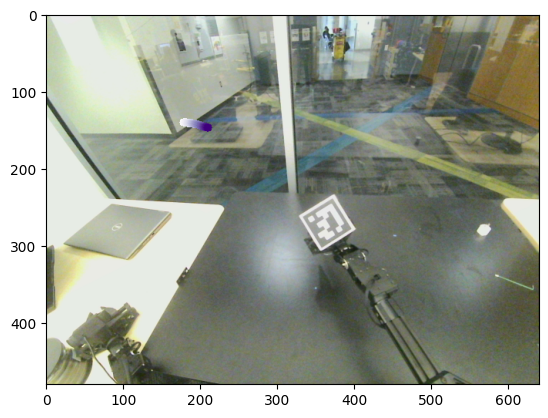

In [26]:
T = 200
# inverted robot: (x forward, y right, z down) right handed frame
# point = demo["obs/ee_pose"][T][:3][None, :]
rollout = 50
joint_positions = demo["action"][T:T+rollout][:, 7:13]
points = np.zeros((rollout, 3))
for i in range(rollout):
    M = np.array([[1.0, 0.0, 0.0, 0.536494],
                [0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.42705],
                [0.0, 0.0, 0.0, 1.0]])

    Slist = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                      [0.0, 1.0, 0.0, -0.12705, 0.0, 0.0],
                      [0.0, 1.0, 0.0, -0.42705, 0.0, 0.05955],
                      [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0],
                      [0.0, 1.0, 0.0, -0.42705, 0.0, 0.35955],
                      [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0]]).T
    # print(joint_positions[i])
    T_obs = FKinSpace(M, Slist, joint_positions[i])
    # print(T_obs)
    points[i] = T_obs[:3, 3]
px_val = ee_pose_to_cam_pixels(points, EXTRINSICS["humanoidFeb27"], WIDE_LENS_ROBOT_LEFT_K)
plt.imshow(draw_dot_on_frame(demo["observations/images/cam_high"][T], px_val, show=False))

# IK ground up

In [ ]:
import h5py
import matplotlib.pyplot as plt

In [ ]:
file = h5py.File("/coc/flash7/skareer6/episode_0.hdf5", "r")
file["observations/qpos"].shape
joint_poses = file["observations/qpos"][0:700]

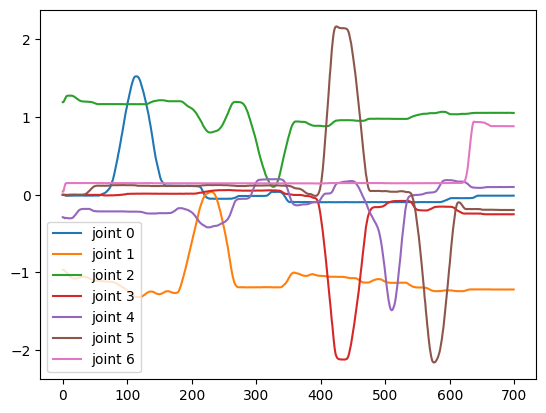

In [ ]:
# plt.plot(joint_poses)
#plot each joint in joint_poses and label it in the legend
joint_poses = joint_poses[:, 0:7]
for i in range(joint_poses.shape[1]):
    plt.plot(joint_poses[:,i], label="joint {}".format(i))
plt.legend()
plt.show()

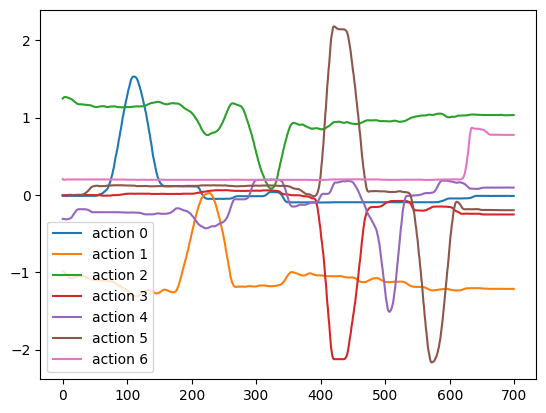

In [ ]:
# plot same for actions
actions = file["action"][:, :7]
for i in range(actions.shape[1]):
    plt.plot(actions[:,i], label="action {}".format(i))
plt.legend()
plt.show()

## Next check the poses for 2 known positions

In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from modern_robotics import FKinSpace

In [ ]:
file = h5py.File("/coc/flash7/skareer6/touch_points.hdf5", "r")

In [ ]:
M = np.array([[1.0, 0.0, 0.0, 0.536494],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.42705],
    [0.0, 0.0, 0.0, 1.0]])

Slist = np.array([[0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, -0.12705, 0.0, 0.0],
    [0.0, 1.0, 0.0, -0.42705, 0.0, 0.05955],
    [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0],
    [0.0, 1.0, 0.0, -0.42705, 0.0, 0.35955],
    [1.0, 0.0, 0.0, 0.0, 0.42705, 0.0]]).T

In [ ]:
joint_poses = file["observations/qpos"][0:700]

[[ 0.72 -0.12  0.69  0.34]
 [ 0.13  0.99  0.04  0.09]
 [-0.68  0.06  0.73  0.03]
 [ 0.    0.    0.    1.  ]]


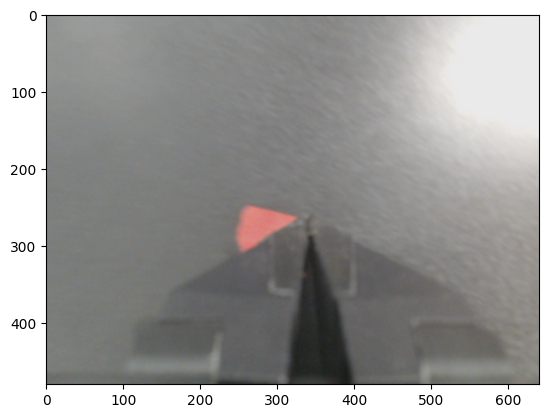

In [ ]:
T = 200
# print joint pos and show camera image
joint_poses = joint_poses[:, 0:7]
# print(joint_poses[T])
plt.imshow(file["observations/images/cam_left_wrist"][T])
trans = FKinSpace(M, Slist, joint_poses[T][:6])
print(trans.round(2))